### Import Libraries

In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### Function: Reduce Memory

In [2]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
sns.set(rc={'figure.figsize':(11,8)})
sns.set(style='whitegrid')

### Load Data 1: Full Set

In [4]:
building0 = pd.read_csv('/Users/feihuyan/Downloads/EnergyData/building_metadata.csv')
train0 = pd.read_csv('/Users/feihuyan/Downloads/EnergyData/train.csv', parse_dates=['timestamp'])
test0 = pd.read_csv('/Users/feihuyan/Downloads/EnergyData/test.csv', parse_dates=['timestamp'])
weather_train0 = pd.read_csv('/Users/feihuyan/Downloads/EnergyData/weather_train.csv', parse_dates=['timestamp'])
weather_test0 = pd.read_csv('/Users/feihuyan/Downloads/EnergyData/weather_test.csv', parse_dates=['timestamp'])

In [4]:
train0 = pd.read_csv('/Users/feihuyan/Downloads/EnergyData/train.csv', parse_dates=['timestamp'])
train0.shape

(20216100, 4)

In [5]:
building = building0.copy()
weather_train = weather_train0.copy()
weather_test = weather_test0.copy()
train = train0.copy()
test = test0.copy()

### Feature: Building 'primary_use' Label Encoding

In [290]:
primary_use_list = building['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)
building['primary_use'] = building['primary_use'].map(primary_use_dict)

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}


### Feature: Building 'primary_use' Mean Encoding

In [291]:
traintemp = train.merge(building, on='building_id', how='left')
traintemp = traintemp.merge(weather_train, on=['site_id','timestamp'], how='left')
me = traintemp.groupby(['primary_use']).meter_reading.mean()

In [292]:
me_df = pd.DataFrame(me)

In [293]:
mm_scaler = preprocessing.MinMaxScaler()
me_df = mm_scaler.fit_transform(me_df)
me_df1 = pd.DataFrame(me_df)
me_df1['primary_use']=me_df1.index
me_df1.set_index('primary_use', inplace=True)
me_s = me_df1.squeeze()
me_s

primary_use
0     1.000000
1     0.059902
2     0.113791
3     0.102300
4     0.029113
5     0.029348
6     0.035812
7     0.061764
8     0.010696
9     0.065404
10    0.000000
11    0.160102
12    0.110784
13    0.029004
14    0.061253
15    0.897019
Name: 0, dtype: float64

In [294]:
building['primary_use'] = building['primary_use'].map(me_s)
building.head()

site_id  building_id  primary_use  square_feet  year_built  floor_count
0        0            0          1.0         7432      2008.0          NaN
1        0            1          1.0         2720      2004.0          NaN
2        0            2          1.0         5376      1991.0          NaN
3        0            3          1.0        23685      2002.0          NaN
4        0            4          1.0       116607      1975.0          NaN

### Feature: Building 'floor_count' Imputation (MICE)

In [295]:
from impyute.imputation.cs import mice
buildinga = building[['square_feet', 'floor_count']]
buildinga = mice(buildinga)
buildinga.columns=['square_feet', 'floor_count']
buildingnotfull = building.drop(['square_feet','floor_count'],axis=1)
building = pd.concat([buildingnotfull, buildinga], axis=1)
building.head()

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/impyute/util/preprocess.py:52: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



site_id  building_id  primary_use  year_built  square_feet  floor_count
0        0            0          1.0      2008.0       7432.0     2.623014
1        0            1          1.0      2004.0       2720.0     2.541934
2        0            2          1.0      1991.0       5376.0     2.587636
3        0            3          1.0      2002.0      23685.0     2.902681
4        0            4          1.0      1975.0     116607.0     4.501599

### UCF Leak 

In [296]:
leak_df = pd.read_pickle('/Users/feihuyan/site0.pkl') 
leak_df['meter_reading'] = leak_df.meter_reading_scraped
leak_df.drop(['meter_reading_original','meter_reading_scraped'], axis=1, inplace=True)
leak_df.fillna(0, inplace=True)
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0
leak_df = leak_df[leak_df.timestamp.dt.year > 2016]
print(len(leak_df))

2260080


In [297]:
train_df = pd.concat([train, leak_df])
train_df.reset_index(inplace=True)
weather_train = pd.concat([weather_train, weather_test])
weather_train.reset_index(inplace=True)

In [298]:
del leak_df
gc.collect()

279

### Feature: Datetime -> Datetime Segments

In [299]:
train_df['date'] = train_df['timestamp'].dt.date
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])

In [300]:
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

In [301]:
def preprocess(df):
    df["hour"] = df["timestamp"].dt.hour
#     df["day"] = df["timestamp"].dt.day
    df["weekend"] = df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month
    df["dayofweek"] = df["timestamp"].dt.dayofweek

#     hour_rad = df["hour"].values / 24. * 2 * np.pi
#     df["hour_sin"] = np.sin(hour_rad)
#     df["hour_cos"] = np.cos(hour_rad)

In [302]:
preprocess(train_df)

In [303]:
train_df.head()

index  building_id  meter  timestamp  meter_reading        date  \
103    103          105      0 2016-01-01        23.3036  2016-01-01   
104    104          106      0 2016-01-01         0.3746  2016-01-01   
105    105          106      3 2016-01-01         0.0000  2016-01-01   
106    106          107      0 2016-01-01       175.1840  2016-01-01   
107    107          108      0 2016-01-01        91.2653  2016-01-01   

     meter_reading_log1p  hour  weekend  month  dayofweek  
103             3.190624     0        4      1          4  
104             0.318163     0        4      1          4  
105             0.000000     0        4      1          4  
106             5.171529     0        4      1          4  
107             4.524668     0        4      1          4

In [304]:
train_df = train_df.sort_values('month')
train_df = train_df.reset_index()

### Feature: Building Target Value -> Summary Statistic Segments 

In [305]:
df_group = train_df.groupby('building_id')['meter_reading_log1p']
building_mean = df_group.mean().astype(np.float16)
building_median = df_group.median().astype(np.float16)
building_min = df_group.min().astype(np.float16)
building_max = df_group.max().astype(np.float16)
building_std = df_group.std().astype(np.float16)

train_df['building_mean'] = train_df['building_id'].map(building_mean)
train_df['building_median'] = train_df['building_id'].map(building_median)
train_df['building_min'] = train_df['building_id'].map(building_min)
train_df['building_max'] = train_df['building_id'].map(building_max)
train_df['building_std'] = train_df['building_id'].map(building_std)
del df_group

### Feature: Weather: Local Time Aligment 

In [366]:
#Align Timestamp
weather1 = pd.concat([weather_train, weather_test],ignore_index=True)
weather_key=['site_id', 'timestamp']

temp_skeleton = weather1[weather_key + ['air_temperature']].drop_duplicates(subset=weather_key).sort_values(by=weather_key).copy()

#calculate ranks of hourly temperatures within date/site_id chunks
temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.date])['air_temperature'].rank('average')

#create a df of site_id(0-16) * mean hour rank of temperature within day (0-23)
df_2d = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

# Subtract the columnID of temperature peak by 14, getting the timestamp alignment gap.
site_ids_offsets = pd.Series(df_2d.values.argmax(axis=1) - 14)
site_ids_offsets.index.name = 'site_id'

def timestamp_align(df):
    df['offset'] = df.site_id.map(site_ids_offsets)
    df['timestamp_aligned'] = (df.timestamp - pd.to_timedelta(df.offset, unit='H'))
    df['timestamp'] = df['timestamp_aligned']
    del df['timestamp_aligned']
    return df

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [307]:
weather_train = timestamp_align(weather_train)

In [308]:
del weather1
del df_2d
del temp_skeleton
site_ids_offsets

### Feature: Weather Interpolate 

In [309]:
#weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

In [310]:
weather_train = weather_train.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

In [311]:
#weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

### Function: Weather -> Weather Lag

In [312]:
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

### Feature: Weather -> Weather Lag

In [313]:
add_lag_feature(weather_train, window=3) 

In [314]:
pd.DataFrame(weather_train.isna().sum().sort_values(ascending=False), columns=['NaN Count'])

NaN Count
precip_depth_1_hr_std_lag3        78093
precip_depth_1_hr_min_lag3        78080
precip_depth_1_hr                 78080
precip_depth_1_hr_max_lag3        78080
precip_depth_1_hr_mean_lag3       78080
cloud_coverage_std_lag3           50388
cloud_coverage_mean_lag3          50374
cloud_coverage_max_lag3           50374
cloud_coverage_min_lag3           50374
cloud_coverage                    50374
sea_level_pressure_std_lag3       26011
sea_level_pressure_min_lag3       25996
sea_level_pressure_max_lag3       25996
sea_level_pressure_mean_lag3      25996
sea_level_pressure                25996
air_temperature_std_lag3             16
wind_speed_std_lag3                  16
dew_temperature_std_lag3             16
wind_direction_std_lag3              16
air_temperature_mean_lag3             0
wind_direction                        0
dew_temperature                       0
air_temperature                       0
timestamp                             0
site_id                               0
wind_speed                            0
offset                                0
dew_temperature_mean_lag3             0
air_temperature_max_lag3              0
air_temperature_min_lag3              0
wind_speed_min_lag3                   0
dew_temperature_max_lag3              0
dew_temperature_min_lag3              0
wind_direction_mean_lag3              0
wind_direction_max_lag3               0
wind_direction_min_lag3               0
wind_speed_mean_lag3                  0
wind_speed_max_lag3                   0
index                                 0

In [315]:
weather_train.head()

index  site_id           timestamp  air_temperature  cloud_coverage  \
0      0        0 2015-12-31 19:00:00             25.0             6.0   
1      1        0 2015-12-31 20:00:00             24.4             4.0   
2      2        0 2015-12-31 21:00:00             22.8             2.0   
3      3        0 2015-12-31 22:00:00             21.1             2.0   
4      4        0 2015-12-31 23:00:00             20.0             2.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             20.0               -1.0              1019.7             0.0   
1             21.1               -1.0              1020.2            70.0   
2             21.1                0.0              1020.2             0.0   
3             20.6                0.0              1020.1             0.0   
4             20.0               -1.0              1020.0           250.0   

   wind_speed  ...  sea_level_pressure_min_lag3  sea_level_pressure_std_lag3  \
0         0.0  ...                       1019.5                          NaN   
1         1.5  ...                       1019.5                     0.353516   
2         0.0  ...                       1019.5                     0.288574   
3         0.0  ...                       1020.0                     0.057739   
4         2.6  ...                       1020.0                     0.099976   

   wind_direction_mean_lag3  wind_direction_max_lag3  wind_direction_min_lag3  \
0                  0.000000                      0.0                      0.0   
1                 35.000000                     70.0                      0.0   
2                 23.328125                     70.0                      0.0   
3                 23.328125                     70.0                      0.0   
4                 83.312500                    250.0                      0.0   

   wind_direction_std_lag3  wind_speed_mean_lag3  wind_speed_max_lag3  \
0                      NaN              0.000000             0.000000   
1                 49.50000              0.750000             1.500000   
2                 40.40625              0.500000             1.500000   
3                 40.40625              0.500000             1.500000   
4                144.37500              0.866699             2.599609   

   wind_speed_min_lag3  wind_speed_std_lag3  
0                  0.0                  NaN  
1                  0.0             1.060547  
2                  0.0             0.866211  
3                  0.0             0.866211  
4                  0.0             1.500977  

[5 rows x 39 columns]

### Feature: Holiday 

In [338]:
#Holiday
dates_range = pd.date_range(start='2015-12-31', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())
train_df['is_holiday'] = (train_df['timestamp'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)
train_df['is_holiday'] = (train_df['timestamp'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)

In [339]:
train_df.head()

level_0    index  building_id  meter           timestamp  meter_reading  \
0      103      103          105      0 2016-01-01 00:00:00      23.303600   
1  1273260  1273260          915      1 2016-01-24 02:00:00      72.763603   
2  1273259  1273259          915      0 2016-01-24 02:00:00     136.000000   
3  1273258  1273258          914      2 2016-01-24 02:00:00     466.649994   
4  1273257  1273257          914      1 2016-01-24 02:00:00     277.901001   

        date  meter_reading_log1p  hour  weekend  month  dayofweek  \
0 2016-01-01             3.191406     0        4      1          4   
1 2016-01-24             4.300781     2        6      1          6   
2 2016-01-24             4.921875     2        6      1          6   
3 2016-01-24             6.148438     2        6      1          6   
4 2016-01-24             5.628906     2        6      1          6   

   building_mean  building_median  building_min  building_max  building_std  \
0       4.316406         4.332031      3.191406      5.164062      0.318115   
1       4.867188         5.187500      0.000000      8.085938      1.359375   
2       4.867188         5.187500      0.000000      8.085938      1.359375   
3       5.640625         5.925781      0.000000      8.976562      1.293945   
4       5.640625         5.925781      0.000000      8.976562      1.293945   

   is_holiday  group  
0           1      1  
1           0      1  
2           0      1  
3           0      1  
4           0      1

In [340]:
# Assuming 5 days a week for all the given buildings
train_df.loc[(train_df['dayofweek'] == 5) | (train_df['dayofweek'] == 6) , 'is_holiday'] = 1
train_df.loc[(train_df['dayofweek'] == 5) | (train_df['dayofweek'] == 6) , 'is_holiday'] = 1

### Feature: Beaufort 

In [341]:
beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
          (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]

for item in beaufort:
    weather_train.loc[(weather_train['wind_speed']>=item[1]) & (weather_train['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

### Feature: Group

In [342]:
train_df['group'] = train_df['month']
train_df['group'].replace((1,2,3,4,5,6), 1,inplace=True)
train_df['group'].replace((7,8,9,10,11,12), 2, inplace=True)

### Reduce Memory

In [352]:
train_df.head()

level_0    index  building_id  meter           timestamp  meter_reading  \
0      103      103          105      0 2016-01-01 00:00:00      23.303600   
1  1273260  1273260          915      1 2016-01-24 02:00:00      72.763603   
2  1273259  1273259          915      0 2016-01-24 02:00:00     136.000000   
3  1273258  1273258          914      2 2016-01-24 02:00:00     466.649994   
4  1273257  1273257          914      1 2016-01-24 02:00:00     277.901001   

        date  meter_reading_log1p  hour  weekend  month  dayofweek  \
0 2016-01-01             3.191406     0        4      1          4   
1 2016-01-24             4.300781     2        6      1          6   
2 2016-01-24             4.921875     2        6      1          6   
3 2016-01-24             6.148438     2        6      1          6   
4 2016-01-24             5.628906     2        6      1          6   

   building_mean  building_median  building_min  building_max  building_std  \
0       4.316406         4.332031      3.191406      5.164062      0.318115   
1       4.867188         5.187500      0.000000      8.085938      1.359375   
2       4.867188         5.187500      0.000000      8.085938      1.359375   
3       5.640625         5.925781      0.000000      8.976562      1.293945   
4       5.640625         5.925781      0.000000      8.976562      1.293945   

   is_holiday  group  
0           1      1  
1           1      1  
2           1      1  
3           1      1  
4           1      1

In [343]:
reduce_mem_usage(train_df, use_float16=True)
reduce_mem_usage(building, use_float16=True)
reduce_mem_usage(weather_train, use_float16=True)

Memory usage of dataframe is 1055.29 MB
Memory usage after optimization is: 907.55 MB
Decreased by 14.0%
Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.02 MB
Decreased by 0.0%
Memory usage of dataframe is 34.20 MB
Memory usage after optimization is: 34.20 MB
Decreased by 0.0%


index  site_id           timestamp  air_temperature  cloud_coverage  \
0            0        0 2015-12-31 19:00:00        25.000000        6.000000   
1            1        0 2015-12-31 20:00:00        24.406250        4.000000   
2            2        0 2015-12-31 21:00:00        22.796875        2.000000   
3            3        0 2015-12-31 22:00:00        21.093750        2.000000   
4            4        0 2015-12-31 23:00:00        20.000000        2.000000   
5            5        0 2016-01-01 00:00:00        19.406250        4.000000   
6            6        0 2016-01-01 01:00:00        21.093750        6.000000   
7            7        0 2016-01-01 02:00:00        21.093750        6.000000   
8            8        0 2016-01-01 03:00:00        20.593750        6.000000   
9            9        0 2016-01-01 04:00:00        21.093750        6.000000   
10          10        0 2016-01-01 05:00:00        21.093750        6.000000   
11          11        0 2016-01-01 06:00:00        20.593750        6.000000   
12          12        0 2016-01-01 07:00:00        18.906250        6.000000   
13          13        0 2016-01-01 08:00:00        20.000000        6.000000   
14          14        0 2016-01-01 09:00:00        21.703125        6.000000   
15          15        0 2016-01-01 10:00:00        23.906250        6.000000   
16          16        0 2016-01-01 11:00:00        26.093750        6.000000   
17          17        0 2016-01-01 12:00:00        26.703125        6.000000   
18          18        0 2016-01-01 13:00:00        27.796875        6.000000   
19          19        0 2016-01-01 14:00:00        28.296875        6.000000   
20          20        0 2016-01-01 15:00:00        28.296875        6.000000   
21          21        0 2016-01-01 16:00:00        27.796875        6.000000   
22          22        0 2016-01-01 17:00:00        26.703125        6.000000   
23          23        0 2016-01-01 18:00:00        25.593750        6.000000   
24          24        0 2016-01-01 19:00:00        24.406250        6.000000   
25          25        0 2016-01-01 20:00:00        23.906250        4.000000   
26          26        0 2016-01-01 21:00:00        22.203125        4.000000   
27          27        0 2016-01-01 22:00:00        21.093750        4.000000   
28          28        0 2016-01-01 23:00:00        20.593750        4.000000   
29          29        0 2016-01-02 00:00:00        19.406250        4.000000   
...        ...      ...                 ...              ...             ...   
416986  277213       15 2018-12-30 12:00:00         1.099609        3.455078   
416987  277214       15 2018-12-30 13:00:00         1.099609        3.544922   
416988  277215       15 2018-12-30 14:00:00         1.099609        3.636719   
416989  277216       15 2018-12-30 15:00:00         1.099609        3.726562   
416990  277217       15 2018-12-30 16:00:00         0.600098        3.818359   
416991  277218       15 2018-12-30 17:00:00         0.000000        3.908203   
416992  277219       15 2018-12-30 18:00:00        -1.099609        4.000000   
416993  277220       15 2018-12-30 19:00:00        -1.099609        2.000000   
416994  277221       15 2018-12-30 20:00:00        -1.700195        0.000000   
416995  277222       15 2018-12-30 21:00:00        -2.199219        0.000000   
416996  277223       15 2018-12-30 22:00:00        -1.700195        0.000000   
416997  277224       15 2018-12-30 23:00:00        -1.700195        0.000000   
416998  277225       15 2018-12-31 00:00:00        -2.199219        0.000000   
416999  277226       15 2018-12-31 01:00:00        -2.199219        0.000000   
417000  277227       15 2018-12-31 02:00:00        -3.900391        0.000000   
417001  277228       15 2018-12-31 03:00:00        -3.300781        0.000000   
417002  277229       15 2018-12-31 04:00:00        -4.398438        0.000000   
417003  277230       15 2018-12-31 05:00:00        -4.398438        0.000000   
417004  2

In [375]:
category_cols = ['building_id', 'site_id', 'primary_use']  # , 'meter'
feature_cols = [
       'hour', 'weekend',
       'month', 'dayofweek', 'building_mean', 'building_median',
       'building_min', 'building_max', 'building_std', 'is_holiday', 'group',
       'year_built', 'square_feet',
       'floor_count',
               'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'offset', 'air_temperature_mean_lag3',
       'air_temperature_max_lag3', 'air_temperature_min_lag3',
       'air_temperature_std_lag3', 'cloud_coverage_mean_lag3',
       'cloud_coverage_max_lag3', 'cloud_coverage_min_lag3',
       'cloud_coverage_std_lag3', 'dew_temperature_mean_lag3',
       'dew_temperature_max_lag3', 'dew_temperature_min_lag3',
       'dew_temperature_std_lag3', 'precip_depth_1_hr_mean_lag3',
       'precip_depth_1_hr_max_lag3', 'precip_depth_1_hr_min_lag3',
       'precip_depth_1_hr_std_lag3', 'sea_level_pressure_mean_lag3',
       'sea_level_pressure_max_lag3', 'sea_level_pressure_min_lag3',
       'sea_level_pressure_std_lag3', 'wind_direction_mean_lag3',
       'wind_direction_max_lag3', 'wind_direction_min_lag3',
       'wind_direction_std_lag3', 'wind_speed_mean_lag3',
       'wind_speed_max_lag3', 'wind_speed_min_lag3', 'wind_speed_std_lag3',
       'beaufort_scale']

In [376]:
def create_X_y(train_df, target_meter):
    target_train_df = train_df[train_df['meter'] == target_meter]
    target_train_df = target_train_df.merge(building, on='building_id', how='left')
    target_train_df = target_train_df.merge(weather_train, on=['site_id', 'timestamp'], how='left')
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['meter_reading_log1p'].values

    del target_train_df
    return X_train, y_train

In [377]:
def fit_lgbm(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'rmse'
    params = {'num_leaves': 31,
              'objective': 'regression',
#               'max_depth': -1,
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,
#               "verbosity": -1,
#               'reg_alpha': 0.1,
#               'reg_lambda': 0.3
              }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['rmse'],
           'valid/mae': model.best_score['valid_1']['rmse']}
    return model, y_pred_valid, log

In [378]:
folds = 5
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)
oof_total = 0

target_meter 0 (13554296, 54)
cat_features [51, 52, 53]
train 10843436 valid 2710860
training LGB:


/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.832481	valid_1's rmse: 0.855262
[40]	training's rmse: 0.63777	valid_1's rmse: 0.684568
[60]	training's rmse: 0.58606	valid_1's rmse: 0.644982
[80]	training's rmse: 0.558868	valid_1's rmse: 0.631052
[100]	training's rmse: 0.531936	valid_1's rmse: 0.621672
[120]	training's rmse: 0.511594	valid_1's rmse: 0.613788
[140]	training's rmse: 0.495453	valid_1's rmse: 0.604261
[160]	training's rmse: 0.478447	valid_1's rmse: 0.595277
[180]	training's rmse: 0.466045	valid_1's rmse: 0.589168
[200]	training's rmse: 0.455639	valid_1's rmse: 0.582239
[220]	training's rmse: 0.446296	valid_1's rmse: 0.575882
[240]	training's rmse: 0.439595	valid_1's rmse: 0.572934
[260]	training's rmse: 0.433613	valid_1's rmse: 0.571455
[280]	training's rmse: 0.428582	valid_1's rmse: 0.570077
[300]	training's rmse: 0.423812	valid_1's rmse: 0.569478
Did not meet early stopping. Best iteration is:
[300]	training's rmse: 0.423812	valid_1's 

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.849687	valid_1's rmse: 0.792828
[40]	training's rmse: 0.661766	valid_1's rmse: 0.585527
[60]	training's rmse: 0.611605	valid_1's rmse: 0.534962
[80]	training's rmse: 0.585119	valid_1's rmse: 0.515239
[100]	training's rmse: 0.55464	valid_1's rmse: 0.50299
[120]	training's rmse: 0.531564	valid_1's rmse: 0.493391
[140]	training's rmse: 0.514627	valid_1's rmse: 0.483816
[160]	training's rmse: 0.50097	valid_1's rmse: 0.477418
[180]	training's rmse: 0.489426	valid_1's rmse: 0.472567
[200]	training's rmse: 0.479585	valid_1's rmse: 0.467062
[220]	training's rmse: 0.47076	valid_1's rmse: 0.463015
[240]	training's rmse: 0.463092	valid_1's rmse: 0.460865
[260]	training's rmse: 0.456909	valid_1's rmse: 0.459938
[280]	training's rmse: 0.450008	valid_1's rmse: 0.458289
[300]	training's rmse: 0.44368	valid_1's rmse: 0.457001
Did not meet early stopping. Best iteration is:
[300]	training's rmse: 0.44368	valid_1's rmse

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.82918	valid_1's rmse: 0.870963
[40]	training's rmse: 0.635156	valid_1's rmse: 0.698726
[60]	training's rmse: 0.583108	valid_1's rmse: 0.657194
[80]	training's rmse: 0.552005	valid_1's rmse: 0.639938
[100]	training's rmse: 0.526896	valid_1's rmse: 0.62594
[120]	training's rmse: 0.508465	valid_1's rmse: 0.616152
[140]	training's rmse: 0.493736	valid_1's rmse: 0.609485
[160]	training's rmse: 0.481471	valid_1's rmse: 0.604124
[180]	training's rmse: 0.470325	valid_1's rmse: 0.600652
[200]	training's rmse: 0.45919	valid_1's rmse: 0.596827
[220]	training's rmse: 0.448598	valid_1's rmse: 0.593034
[240]	training's rmse: 0.441015	valid_1's rmse: 0.589856
[260]	training's rmse: 0.434183	valid_1's rmse: 0.587197
[280]	training's rmse: 0.42806	valid_1's rmse: 0.585769
[300]	training's rmse: 0.421838	valid_1's rmse: 0.584342
Did not meet early stopping. Best iteration is:
[300]	training's rmse: 0.421838	valid_1's rm

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.824631	valid_1's rmse: 0.905303
[40]	training's rmse: 0.63556	valid_1's rmse: 0.738246
[60]	training's rmse: 0.586846	valid_1's rmse: 0.695723
[80]	training's rmse: 0.561572	valid_1's rmse: 0.675961
[100]	training's rmse: 0.538979	valid_1's rmse: 0.662746
[120]	training's rmse: 0.518516	valid_1's rmse: 0.651916
[140]	training's rmse: 0.503366	valid_1's rmse: 0.644186
[160]	training's rmse: 0.490908	valid_1's rmse: 0.638076
[180]	training's rmse: 0.478771	valid_1's rmse: 0.633413
[200]	training's rmse: 0.46927	valid_1's rmse: 0.629707
[220]	training's rmse: 0.460829	valid_1's rmse: 0.625073
[240]	training's rmse: 0.454002	valid_1's rmse: 0.619728
[260]	training's rmse: 0.446658	valid_1's rmse: 0.617257
[280]	training's rmse: 0.440286	valid_1's rmse: 0.616363
[300]	training's rmse: 0.434352	valid_1's rmse: 0.613892
Did not meet early stopping. Best iteration is:
[300]	training's rmse: 0.434352	valid_1's 

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.834198	valid_1's rmse: 0.854746
[40]	training's rmse: 0.64062	valid_1's rmse: 0.694935
[60]	training's rmse: 0.588208	valid_1's rmse: 0.666885
[80]	training's rmse: 0.55787	valid_1's rmse: 0.662304
[100]	training's rmse: 0.529375	valid_1's rmse: 0.660578
[120]	training's rmse: 0.507806	valid_1's rmse: 0.664562
Early stopping, best iteration is:
[104]	training's rmse: 0.525219	valid_1's rmse: 0.658069
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('rmse', 0.5252193916600153)]), 'valid_1': OrderedDict([('rmse', 0.6580686031523503)])})


15

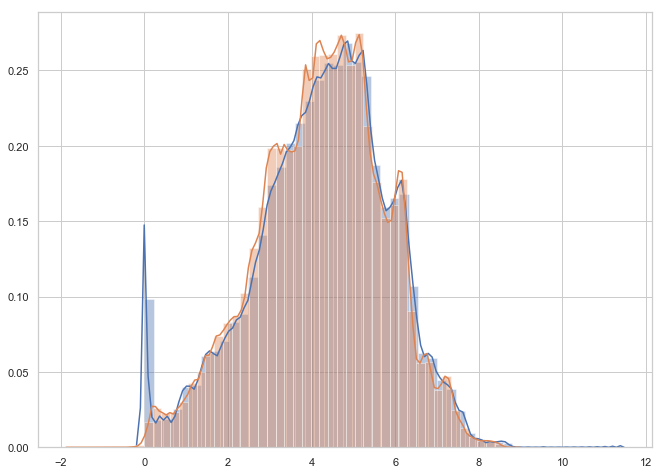

In [379]:
target_meter = 0
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models0 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=300, lr=0.05, bf=0.7)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models0.append(model)
    gc.collect()

sns.distplot(y_train)
sns.distplot(y_valid_pred_total)

oof0 = mean_squared_error(y_train, y_valid_pred_total)
oof_total += oof0 * len(y_train)

del X_train, y_train
gc.collect()

target_meter 1 (4602920, 54)
cat_features [51, 52, 53]
train 3682336 valid 920584
training LGB:


/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 1.6623	valid_1's rmse: 1.90394
[40]	training's rmse: 1.42441	valid_1's rmse: 1.65691
[60]	training's rmse: 1.32843	valid_1's rmse: 1.58607
[80]	training's rmse: 1.26298	valid_1's rmse: 1.52887
[100]	training's rmse: 1.21731	valid_1's rmse: 1.48782
[120]	training's rmse: 1.18286	valid_1's rmse: 1.44579
[140]	training's rmse: 1.15682	valid_1's rmse: 1.42575
[160]	training's rmse: 1.13477	valid_1's rmse: 1.40993
[180]	training's rmse: 1.11611	valid_1's rmse: 1.40463
[200]	training's rmse: 1.09857	valid_1's rmse: 1.39868
[220]	training's rmse: 1.08188	valid_1's rmse: 1.39655
[240]	training's rmse: 1.07064	valid_1's rmse: 1.39401
[260]	training's rmse: 1.05813	valid_1's rmse: 1.3933
[280]	training's rmse: 1.04543	valid_1's rmse: 1.39218
[300]	training's rmse: 1.03549	valid_1's rmse: 1.39023
[320]	training's rmse: 1.02462	valid_1's rmse: 1.38901
[340]	training's rmse: 1.0152	valid_1's rmse: 1.38663
[360]	train

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 1.69208	valid_1's rmse: 1.67729
[40]	training's rmse: 1.4471	valid_1's rmse: 1.47128
[60]	training's rmse: 1.34801	valid_1's rmse: 1.40255
[80]	training's rmse: 1.28238	valid_1's rmse: 1.35595
[100]	training's rmse: 1.23799	valid_1's rmse: 1.32764
[120]	training's rmse: 1.20634	valid_1's rmse: 1.30946
[140]	training's rmse: 1.17962	valid_1's rmse: 1.29707
[160]	training's rmse: 1.15894	valid_1's rmse: 1.28919
[180]	training's rmse: 1.13917	valid_1's rmse: 1.28024
[200]	training's rmse: 1.12187	valid_1's rmse: 1.27259
[220]	training's rmse: 1.10701	valid_1's rmse: 1.26544
[240]	training's rmse: 1.094	valid_1's rmse: 1.25875
[260]	training's rmse: 1.07993	valid_1's rmse: 1.25269
[280]	training's rmse: 1.067	valid_1's rmse: 1.24699
[300]	training's rmse: 1.05671	valid_1's rmse: 1.24289
[320]	training's rmse: 1.04437	valid_1's rmse: 1.23998
[340]	training's rmse: 1.03332	valid_1's rmse: 1.23548
[360]	trainin

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 1.69674	valid_1's rmse: 1.79787
[40]	training's rmse: 1.44152	valid_1's rmse: 1.55266
[60]	training's rmse: 1.34025	valid_1's rmse: 1.46188
[80]	training's rmse: 1.27807	valid_1's rmse: 1.41748
[100]	training's rmse: 1.23089	valid_1's rmse: 1.38712
[120]	training's rmse: 1.19796	valid_1's rmse: 1.3671
[140]	training's rmse: 1.17253	valid_1's rmse: 1.3536
[160]	training's rmse: 1.15311	valid_1's rmse: 1.34169
[180]	training's rmse: 1.13526	valid_1's rmse: 1.33481
[200]	training's rmse: 1.12211	valid_1's rmse: 1.3281
[220]	training's rmse: 1.10863	valid_1's rmse: 1.31995
[240]	training's rmse: 1.09514	valid_1's rmse: 1.31138
[260]	training's rmse: 1.08307	valid_1's rmse: 1.30903
[280]	training's rmse: 1.0714	valid_1's rmse: 1.30556
[300]	training's rmse: 1.05959	valid_1's rmse: 1.30378
[320]	training's rmse: 1.04883	valid_1's rmse: 1.30148
[340]	training's rmse: 1.03999	valid_1's rmse: 1.2997
[360]	trainin

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 1.67058	valid_1's rmse: 1.82525
[40]	training's rmse: 1.4078	valid_1's rmse: 1.62434
[60]	training's rmse: 1.30911	valid_1's rmse: 1.56262
[80]	training's rmse: 1.24582	valid_1's rmse: 1.52928
[100]	training's rmse: 1.19979	valid_1's rmse: 1.50471
[120]	training's rmse: 1.16668	valid_1's rmse: 1.48635
[140]	training's rmse: 1.14296	valid_1's rmse: 1.47972
[160]	training's rmse: 1.12344	valid_1's rmse: 1.47467
[180]	training's rmse: 1.10506	valid_1's rmse: 1.46892
[200]	training's rmse: 1.09264	valid_1's rmse: 1.46391
[220]	training's rmse: 1.07941	valid_1's rmse: 1.4615
[240]	training's rmse: 1.06645	valid_1's rmse: 1.45791
[260]	training's rmse: 1.05517	valid_1's rmse: 1.45267
[280]	training's rmse: 1.04433	valid_1's rmse: 1.4467
[300]	training's rmse: 1.03598	valid_1's rmse: 1.44363
[320]	training's rmse: 1.02722	valid_1's rmse: 1.43813
[340]	training's rmse: 1.01926	valid_1's rmse: 1.43648
[360]	train

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 1.68707	valid_1's rmse: 1.79067
[40]	training's rmse: 1.43015	valid_1's rmse: 1.55537
[60]	training's rmse: 1.32295	valid_1's rmse: 1.49169
[80]	training's rmse: 1.26097	valid_1's rmse: 1.47898
[100]	training's rmse: 1.21854	valid_1's rmse: 1.47285
[120]	training's rmse: 1.18315	valid_1's rmse: 1.47004
[140]	training's rmse: 1.15925	valid_1's rmse: 1.4689
Early stopping, best iteration is:
[129]	training's rmse: 1.17143	valid_1's rmse: 1.46577
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('rmse', 1.1714343494092014)]), 'valid_1': OrderedDict([('rmse', 1.4657706276511373)])})


15

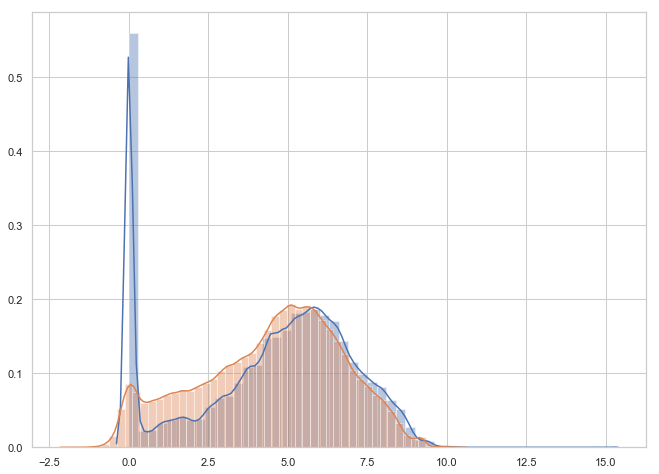

In [380]:
target_meter = 1
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models1 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=500,
                                       lr=0.05, bf=0.5)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models1.append(model)
    gc.collect()

sns.distplot(y_train)
sns.distplot(y_valid_pred_total)

oof1 = mean_squared_error(y_train, y_valid_pred_total)
oof_total += oof1 * len(y_train)

del X_train, y_train
gc.collect()

target_meter 2 (2708713, 54)
cat_features [51, 52, 53]
train 2166970 valid 541743
training LGB:


/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 1.63577	valid_1's rmse: 1.82739
[40]	training's rmse: 1.37132	valid_1's rmse: 1.5785
[60]	training's rmse: 1.26828	valid_1's rmse: 1.50162
[80]	training's rmse: 1.21345	valid_1's rmse: 1.46847
[100]	training's rmse: 1.17594	valid_1's rmse: 1.45546
[120]	training's rmse: 1.14735	valid_1's rmse: 1.44318
[140]	training's rmse: 1.12526	valid_1's rmse: 1.43327
[160]	training's rmse: 1.10696	valid_1's rmse: 1.42818
[180]	training's rmse: 1.09332	valid_1's rmse: 1.42414
[200]	training's rmse: 1.08059	valid_1's rmse: 1.41877
[220]	training's rmse: 1.06965	valid_1's rmse: 1.4178
[240]	training's rmse: 1.05961	valid_1's rmse: 1.41542
[260]	training's rmse: 1.0515	valid_1's rmse: 1.41266
[280]	training's rmse: 1.04507	valid_1's rmse: 1.41163
[300]	training's rmse: 1.03825	valid_1's rmse: 1.40999
[320]	training's rmse: 1.03346	valid_1's rmse: 1.40895
[340]	training's rmse: 1.02766	valid_1's rmse: 1.40836
[360]	train

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 1.6254	valid_1's rmse: 1.68683
[40]	training's rmse: 1.3654	valid_1's rmse: 1.51015
[60]	training's rmse: 1.26385	valid_1's rmse: 1.43554
[80]	training's rmse: 1.21289	valid_1's rmse: 1.39761
[100]	training's rmse: 1.17769	valid_1's rmse: 1.37799
[120]	training's rmse: 1.14779	valid_1's rmse: 1.35914
[140]	training's rmse: 1.12628	valid_1's rmse: 1.3475
[160]	training's rmse: 1.109	valid_1's rmse: 1.34084
[180]	training's rmse: 1.09422	valid_1's rmse: 1.3345
[200]	training's rmse: 1.08137	valid_1's rmse: 1.32566
[220]	training's rmse: 1.07066	valid_1's rmse: 1.32002
[240]	training's rmse: 1.06078	valid_1's rmse: 1.3141
[260]	training's rmse: 1.05126	valid_1's rmse: 1.30799
[280]	training's rmse: 1.04247	valid_1's rmse: 1.30478
[300]	training's rmse: 1.03424	valid_1's rmse: 1.29837
[320]	training's rmse: 1.02665	valid_1's rmse: 1.29521
[340]	training's rmse: 1.02089	valid_1's rmse: 1.29344
[360]	training'

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 1.61483	valid_1's rmse: 1.89277
[40]	training's rmse: 1.35473	valid_1's rmse: 1.60935
[60]	training's rmse: 1.24387	valid_1's rmse: 1.50733
[80]	training's rmse: 1.17999	valid_1's rmse: 1.46373
[100]	training's rmse: 1.13566	valid_1's rmse: 1.44434
[120]	training's rmse: 1.10922	valid_1's rmse: 1.42861
[140]	training's rmse: 1.09068	valid_1's rmse: 1.41982
[160]	training's rmse: 1.07503	valid_1's rmse: 1.41185
[180]	training's rmse: 1.06162	valid_1's rmse: 1.40475
[200]	training's rmse: 1.05058	valid_1's rmse: 1.3987
[220]	training's rmse: 1.04039	valid_1's rmse: 1.39235
[240]	training's rmse: 1.03009	valid_1's rmse: 1.38792
[260]	training's rmse: 1.02141	valid_1's rmse: 1.38241
[280]	training's rmse: 1.01383	valid_1's rmse: 1.37985
[300]	training's rmse: 1.00613	valid_1's rmse: 1.37656
[320]	training's rmse: 0.999948	valid_1's rmse: 1.37415
[340]	training's rmse: 0.994326	valid_1's rmse: 1.37055
[360]	t

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 1.60695	valid_1's rmse: 1.80586
[40]	training's rmse: 1.33006	valid_1's rmse: 1.58124
[60]	training's rmse: 1.22585	valid_1's rmse: 1.51955
[80]	training's rmse: 1.16977	valid_1's rmse: 1.48319
[100]	training's rmse: 1.13675	valid_1's rmse: 1.45449
[120]	training's rmse: 1.11127	valid_1's rmse: 1.44408
[140]	training's rmse: 1.09288	valid_1's rmse: 1.43686
[160]	training's rmse: 1.07964	valid_1's rmse: 1.43113
[180]	training's rmse: 1.06862	valid_1's rmse: 1.4276
[200]	training's rmse: 1.05758	valid_1's rmse: 1.42508
[220]	training's rmse: 1.04716	valid_1's rmse: 1.42351
[240]	training's rmse: 1.03675	valid_1's rmse: 1.42052
[260]	training's rmse: 1.02826	valid_1's rmse: 1.42007
[280]	training's rmse: 1.01962	valid_1's rmse: 1.41881
[300]	training's rmse: 1.01265	valid_1's rmse: 1.41672
[320]	training's rmse: 1.00692	valid_1's rmse: 1.41585
[340]	training's rmse: 1.00119	valid_1's rmse: 1.41489
[360]	tra

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 1.65851	valid_1's rmse: 1.65552
[40]	training's rmse: 1.38847	valid_1's rmse: 1.49707
[60]	training's rmse: 1.28203	valid_1's rmse: 1.42961
[80]	training's rmse: 1.2255	valid_1's rmse: 1.41562
[100]	training's rmse: 1.18796	valid_1's rmse: 1.4042
[120]	training's rmse: 1.16057	valid_1's rmse: 1.40287
Early stopping, best iteration is:
[115]	training's rmse: 1.16658	valid_1's rmse: 1.40072
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('rmse', 1.1665834651443867)]), 'valid_1': OrderedDict([('rmse', 1.4007152592764749)])})


15

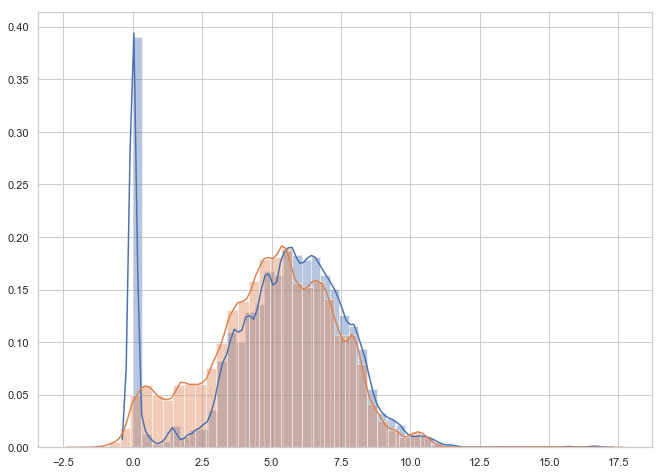

In [381]:
target_meter = 2
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models2 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=500, lr=0.05, bf=0.8)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models2.append(model)
    gc.collect()


sns.distplot(y_train)
sns.distplot(y_valid_pred_total)

oof2 = mean_squared_error(y_train, y_valid_pred_total)
oof_total += oof2 * len(y_train)

del X_train, y_train
gc.collect()

target_meter 3 (1264037, 54)
cat_features [51, 52, 53]
train 1011229 valid 252808
training LGB:


/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 1.89368	valid_1's rmse: 2.10819
[40]	training's rmse: 1.59308	valid_1's rmse: 1.81909
[60]	training's rmse: 1.46124	valid_1's rmse: 1.67027
[80]	training's rmse: 1.39763	valid_1's rmse: 1.58968
[100]	training's rmse: 1.3556	valid_1's rmse: 1.54094
[120]	training's rmse: 1.3251	valid_1's rmse: 1.50233
[140]	training's rmse: 1.29968	valid_1's rmse: 1.4691
[160]	training's rmse: 1.27904	valid_1's rmse: 1.44895
[180]	training's rmse: 1.26525	valid_1's rmse: 1.43875
[200]	training's rmse: 1.25254	valid_1's rmse: 1.43391
[220]	training's rmse: 1.24127	valid_1's rmse: 1.42866
[240]	training's rmse: 1.23191	valid_1's rmse: 1.42528
[260]	training's rmse: 1.22202	valid_1's rmse: 1.42244
[280]	training's rmse: 1.21443	valid_1's rmse: 1.42102
[300]	training's rmse: 1.20867	valid_1's rmse: 1.41961
[320]	training's rmse: 1.20273	valid_1's rmse: 1.4179
[340]	training's rmse: 1.19639	valid_1's rmse: 1.41649
[360]	traini

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 1.88712	valid_1's rmse: 1.93865
[40]	training's rmse: 1.56066	valid_1's rmse: 1.69377
[60]	training's rmse: 1.41554	valid_1's rmse: 1.59769
[80]	training's rmse: 1.34632	valid_1's rmse: 1.55326
[100]	training's rmse: 1.30668	valid_1's rmse: 1.52955
[120]	training's rmse: 1.27819	valid_1's rmse: 1.511
[140]	training's rmse: 1.26028	valid_1's rmse: 1.4969
[160]	training's rmse: 1.24351	valid_1's rmse: 1.48708
[180]	training's rmse: 1.23206	valid_1's rmse: 1.48255
[200]	training's rmse: 1.2212	valid_1's rmse: 1.47861
[220]	training's rmse: 1.21135	valid_1's rmse: 1.47475
[240]	training's rmse: 1.20325	valid_1's rmse: 1.47195
[260]	training's rmse: 1.19646	valid_1's rmse: 1.46952
[280]	training's rmse: 1.19047	valid_1's rmse: 1.46762
[300]	training's rmse: 1.18457	valid_1's rmse: 1.46562
[320]	training's rmse: 1.17945	valid_1's rmse: 1.46461
[340]	training's rmse: 1.1748	valid_1's rmse: 1.4629
[360]	training

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 1.91457	valid_1's rmse: 1.93504
[40]	training's rmse: 1.61396	valid_1's rmse: 1.59198
[60]	training's rmse: 1.47591	valid_1's rmse: 1.44585
[80]	training's rmse: 1.40885	valid_1's rmse: 1.36876
[100]	training's rmse: 1.36869	valid_1's rmse: 1.32745
[120]	training's rmse: 1.33874	valid_1's rmse: 1.29964
[140]	training's rmse: 1.31465	valid_1's rmse: 1.28284
[160]	training's rmse: 1.2954	valid_1's rmse: 1.26561
[180]	training's rmse: 1.28367	valid_1's rmse: 1.26059
[200]	training's rmse: 1.2717	valid_1's rmse: 1.25024
[220]	training's rmse: 1.26206	valid_1's rmse: 1.24063
[240]	training's rmse: 1.25338	valid_1's rmse: 1.23565
[260]	training's rmse: 1.24507	valid_1's rmse: 1.23125
[280]	training's rmse: 1.23863	valid_1's rmse: 1.22758
[300]	training's rmse: 1.23331	valid_1's rmse: 1.22676
[320]	training's rmse: 1.22789	valid_1's rmse: 1.22226
[340]	training's rmse: 1.22247	valid_1's rmse: 1.21883
[360]	trai

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 1.88614	valid_1's rmse: 2.01758
[40]	training's rmse: 1.57434	valid_1's rmse: 1.72354
[60]	training's rmse: 1.42846	valid_1's rmse: 1.60544
[80]	training's rmse: 1.3605	valid_1's rmse: 1.5584
[100]	training's rmse: 1.3217	valid_1's rmse: 1.53155
[120]	training's rmse: 1.29312	valid_1's rmse: 1.51288
[140]	training's rmse: 1.27285	valid_1's rmse: 1.50165
[160]	training's rmse: 1.25507	valid_1's rmse: 1.49258
[180]	training's rmse: 1.24311	valid_1's rmse: 1.48636
[200]	training's rmse: 1.23254	valid_1's rmse: 1.48255
[220]	training's rmse: 1.22263	valid_1's rmse: 1.47847
[240]	training's rmse: 1.2141	valid_1's rmse: 1.47559
[260]	training's rmse: 1.20733	valid_1's rmse: 1.4717
[280]	training's rmse: 1.20117	valid_1's rmse: 1.46876
[300]	training's rmse: 1.19533	valid_1's rmse: 1.46663
[320]	training's rmse: 1.19037	valid_1's rmse: 1.46475
[340]	training's rmse: 1.18501	valid_1's rmse: 1.46237
[360]	trainin

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 1.85666	valid_1's rmse: 2.16514
[40]	training's rmse: 1.5304	valid_1's rmse: 2.01625
[60]	training's rmse: 1.38884	valid_1's rmse: 1.96258
[80]	training's rmse: 1.32253	valid_1's rmse: 1.93226
[100]	training's rmse: 1.2832	valid_1's rmse: 1.90193
[120]	training's rmse: 1.25578	valid_1's rmse: 1.87878
[140]	training's rmse: 1.23226	valid_1's rmse: 1.87762
[160]	training's rmse: 1.21369	valid_1's rmse: 1.8631
[180]	training's rmse: 1.20039	valid_1's rmse: 1.85995
[200]	training's rmse: 1.19078	valid_1's rmse: 1.85885
Early stopping, best iteration is:
[193]	training's rmse: 1.19414	valid_1's rmse: 1.85506
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('rmse', 1.1941434061878586)]), 'valid_1': OrderedDict([('rmse', 1.8550613481680849)])})


15

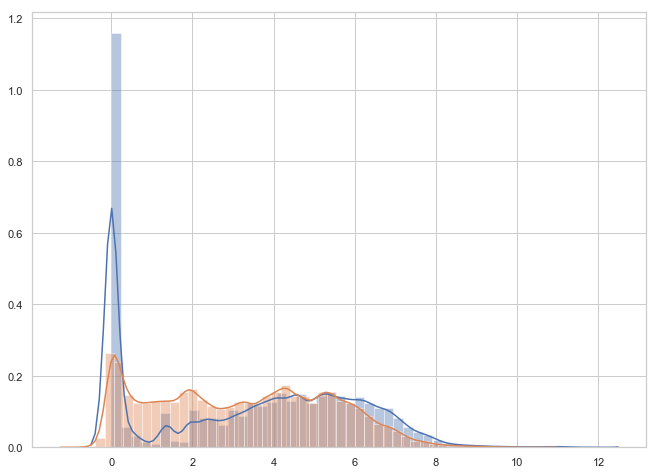

In [382]:
target_meter = 3
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models3 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=500,
                                       lr=0.03, bf=0.9)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models3.append(model)
    gc.collect()

sns.distplot(y_train)
sns.distplot(y_valid_pred_total)

oof3 = mean_squared_error(y_train, y_valid_pred_total)
oof_total += oof3 * len(y_train)

del X_train, y_train
gc.collect()

In [383]:
print ('oof score meter0 =', np.sqrt(oof0))
print ('oof score meter1 =', np.sqrt(oof1))
print ('oof score meter2 =', np.sqrt(oof2))
print ('oof score meter3 =', np.sqrt(oof3))
print ('oof score total  =', np.sqrt(oof_total / len(train_df)))

oof score meter0 = 0.5804358464181067
oof score meter1 = 1.3552032216600622
oof score meter2 = 1.365156919631161
oof score meter3 = 1.4892001188700659
oof score total  = 0.971150564094301


In [384]:
models2

In [385]:
print('loading...')
test = pd.read_csv('/Users/feihuyan/Downloads/EnergyData/test.csv', parse_dates=['timestamp'])
weather_test = pd.read_csv('/Users/feihuyan/Downloads/EnergyData/weather_test.csv', parse_dates=['timestamp'])

print('preprocessing test date...')
test['date'] = test['timestamp'].dt.date

print('preprocessing test date seg...')
preprocess(test)

print('preprocessing test building seg...')
test['building_mean'] = test['building_id'].map(building_mean)
test['building_median'] = test['building_id'].map(building_median)
test['building_min'] = test['building_id'].map(building_min)
test['building_max'] = test['building_id'].map(building_max)
test['building_std'] = test['building_id'].map(building_std)

print('preprocessing test holiday...')
#Holiday
dates_range = pd.date_range(start='2015-12-31', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())
test['is_holiday'] = (test['timestamp'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)
test['is_holiday'] = (test['timestamp'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)
# Assuming 5 days a week for all the given buildings
test.loc[(test['dayofweek'] == 5) | (test['dayofweek'] == 6) , 'is_holiday'] = 1
test.loc[(test['dayofweek']) == 5 | (test['dayofweek'] == 6) , 'is_holiday'] = 1

print('preprocessing test group...')
#group
test['group'] = test['month']
test['group'].replace((1,2,3,4,5,6), 1,inplace=True)
test['group'].replace((7,8,9,10,11,12), 2, inplace=True)




print('preprocessing weather align...')
#align
weather_test = timestamp_align(weather_test)

print('preprocessing weather interpolate...')
#interpolate
weather_test = weather_test.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
#weather_test.groupby('site_id').apply(lambda group: group.isna().sum())

print('preprocessing weather lag...')
#lag
add_lag_feature(weather_test, window=3)
#add_lag_feature(weather_test_df, window=72)

print('preprocessing weather beaufort...')
for item in beaufort:
    weather_test.loc[(weather_test['wind_speed']>=item[1]) & (weather_test['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

    
    
    
print('reduce mem usage...')
reduce_mem_usage(test, use_float16=True)
reduce_mem_usage(weather_test, use_float16=True)

gc.collect()

loading...
preprocessing test date...
preprocessing test date seg...
preprocessing test building seg...
preprocessing test holiday...
preprocessing test group...
preprocessing weather align...
preprocessing weather interpolate...
preprocessing weather lag...
preprocessing weather beaufort...
reduce mem usage...
Memory usage of dataframe is 3618.70 MB
Memory usage after optimization is: 1312.30 MB
Decreased by 63.7%
Memory usage of dataframe is 38.07 MB
Memory usage after optimization is: 21.68 MB
Decreased by 43.1%


168

In [374]:
test.head()

row_id  building_id  meter  timestamp       date  hour  weekend  month  \
0       0            0      0 2017-01-01 2017-01-01     0        6      1   
1       1            1      0 2017-01-01 2017-01-01     0        6      1   
2       2            2      0 2017-01-01 2017-01-01     0        6      1   
3       3            3      0 2017-01-01 2017-01-01     0        6      1   
4       4            4      0 2017-01-01 2017-01-01     0        6      1   

   dayofweek  building_mean  building_median  building_min  building_max  \
0          6       5.421875         5.449219           0.0      6.875000   
1          6       4.703125         4.859375           0.0      5.390625   
2          6       3.054688         3.140625           0.0      4.554688   
3          6       5.503906         5.796875           0.0      6.542969   
4          6       7.207031         7.269531           0.0      7.570312   

   building_std  is_holiday  group  
0      0.322266           1      1  
1      0.342041           1      1  
2      0.693848           1      1  
3      0.695312           1      1  
4      0.323242           1      1

In [386]:
sample_submission = pd.read_csv('/Users/feihuyan/Downloads/EnergyData/sample_submission.csv')
reduce_mem_usage(sample_submission)

Memory usage of dataframe is 636.25 MB
Memory usage after optimization is: 198.83 MB
Decreased by 68.7%


row_id  meter_reading
0                0              0
1                1              0
2                2              0
3                3              0
4                4              0
5                5              0
6                6              0
7                7              0
8                8              0
9                9              0
10              10              0
11              11              0
12              12              0
13              13              0
14              14              0
15              15              0
16              16              0
17              17              0
18              18              0
19              19              0
20              20              0
21              21              0
22              22              0
23              23              0
24              24              0
25              25              0
26              26              0
27              27              0
28              28              0
29              29              0
...            ...            ...
41697570  41697570              0
41697571  41697571              0
41697572  41697572              0
41697573  41697573              0
41697574  41697574              0
41697575  41697575              0
41697576  41697576              0
41697577  41697577              0
41697578  41697578              0
41697579  41697579              0
41697580  41697580              0
41697581  41697581              0
41697582  41697582              0
41697583  41697583              0
41697584  41697584              0
41697585  41697585              0
41697586  41697586              0
41697587  41697587              0
41697588  41697588              0
41697589  41697589              0
41697590  41697590              0
41697591  41697591              0
41697592  41697592              0
41697593  41697593              0
41697594  41697594              0
41697595  41697595              0
41697596  41697596              0
41697597  41697597              0
41697598  41697598              0
41697599  41697599              0

[41697600 rows x 2 columns]

In [387]:
def create_X(test_df, target_meter):
    target_test_df = test[test['meter'] == target_meter]
    target_test_df = target_test_df.merge(building, on='building_id', how='left')
    target_test_df = target_test_df.merge(weather_test, on=['site_id', 'timestamp'], how='left')
    X_test = target_test_df[feature_cols + category_cols]
    return X_test

In [388]:
def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total

iterations 25
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model


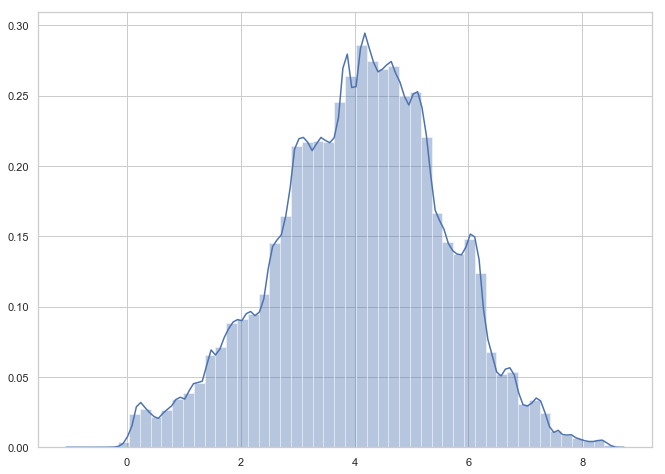

In [389]:
X_test = create_X(test, target_meter=0)
y_test0 = pred(X_test, models0)
sns.distplot(y_test0)

iterations 9
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model


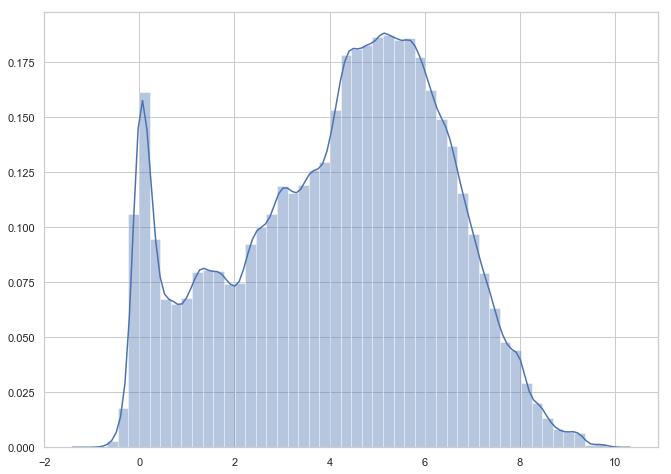

In [390]:
X_test = create_X(test, target_meter=1)
y_test1 = pred(X_test, models1)
sns.distplot(y_test1)

iterations 6
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model


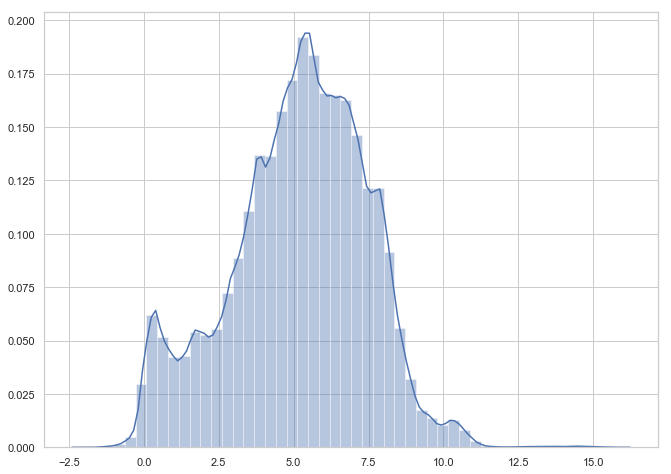

In [391]:
X_test = create_X(test, target_meter=2)
y_test2 = pred(X_test, models2)
sns.distplot(y_test2)

iterations 3
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model


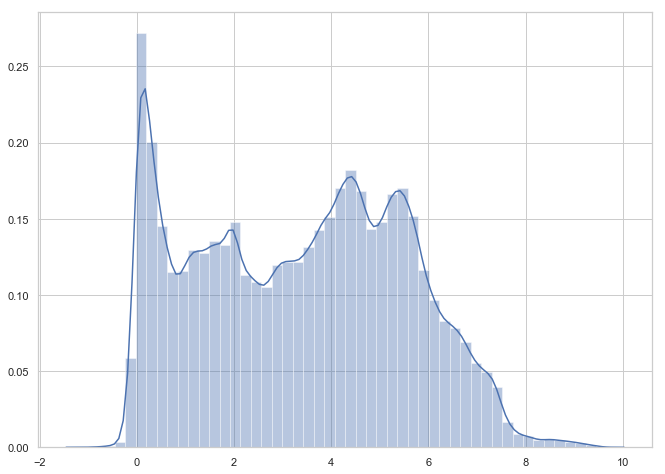

In [392]:
X_test = create_X(test, target_meter=3)
y_test3 = pred(X_test, models3)
sns.distplot(y_test3)

In [165]:
y_test3

array([1.07202914, 1.23774172, 2.2638526 , ..., 8.28017404, 5.55885513,
       8.27511895])

In [393]:
sample_submission.loc[test['meter'] == 0, 'meter_reading'] = np.expm1(y_test0)
sample_submission.loc[test['meter'] == 1, 'meter_reading'] = np.expm1(y_test1)
sample_submission.loc[test['meter'] == 2, 'meter_reading'] = np.expm1(y_test2)
sample_submission.loc[test['meter'] == 3, 'meter_reading'] = np.expm1(y_test3)

In [394]:
sample_submission.to_csv('submission.csv', index=False, float_format='%.4f')

In [395]:
sample_submission.head()

row_id  meter_reading
0       0     199.271640
1       1      83.852851
2       2       9.910312
3       3     146.368264
4       4    1249.984153

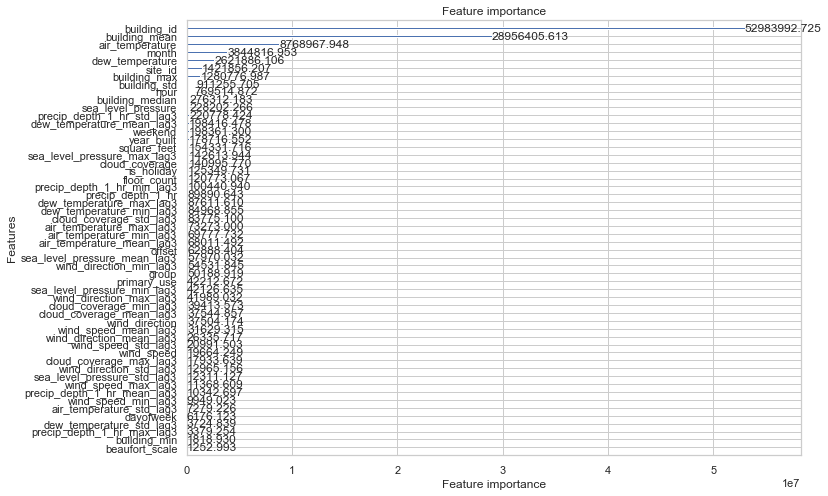

In [399]:
_ = lgb.plot_importance(models2[0],importance_type='gain')